In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tools.dataset import Dataset
from models.processing.create_features import createFeatures
import plotly.graph_objects as go


# Uploading models and data for research

In [2]:
# load pickle data
with open('ensemble.pickle', 'rb') as f:
    ensemble = pickle.load(f)

2022-08-29 19:49:02.189645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 19:49:02.270505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/serg/.mujoco/mujoco210/bin:/home/serg/.mujoco/mujoco210/bin
2022-08-29 19:49:02.275376: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-29 19:49:02.276331: I tensorflow/core/platform/cpu_feature_guar

# 1. Testing how the model predicts candles on the test set
We have 12 models.
* The first model predicts an hour ahead.
* The second model predicts what the candle will be in 2 hours
* The last model predicts what candle will be in 12 hours.

Thus, we have a representation of the price dynamics for the next 12 hours.


Here change the NUMBER_OF_MODEL. 

By default, this is pattern 0, which predicts the next candle

In [6]:
NUMBER_OF_MODEL = 0# 0 - 11
predicted = ensemble.get_predicted()
indexes_split = ensemble.stores[NUMBER_OF_MODEL].indexes_split
price_data = ensemble.stores[NUMBER_OF_MODEL].dataset


In [4]:
train_data = price_data[price_data.index.isin(indexes_split[0])]
test_data = price_data[price_data.index.isin(indexes_split[1])]
print(len(train_data), len(test_data), len(predicted.get(f'LSTM_regressor_{NUMBER_OF_MODEL}')))

561 63 63


In [7]:
predicted_0 = pd.DataFrame(predicted[f'LSTM_regressor_{NUMBER_OF_MODEL}'], columns=['open', 'high', 'low', 'close'])
predicted_0['date'] = test_data.index

# Predicted dataframe
fig = go.Figure(data=[go.Candlestick(
                x=predicted_0['date'],
                open=predicted_0['open'],
                high=predicted_0['high'],
                low=predicted_0['low'],
                close=predicted_0['close'])])

# Actual dataframe
fig_real = go.Figure(data=[go.Candlestick(
                x=test_data.index,
                open=test_data['open'],
                high=test_data['high'],
                low=test_data['low'],
                close=test_data['close'])])

fig.show()
fig_real.show()

In [36]:

TIME_POINT = 20
predicted_total = [predicted[f'LSTM_regressor_{i}'] for i in range(12)]
predicted_series = pd.DataFrame([i[TIME_POINT] for i in predicted_total], columns=['open', 'high', 'low', 'close'])
fig = go.Figure(data=[go.Candlestick(
                x=predicted_series.index,
                open=predicted_series['open'],
                high=predicted_series['high'],
                low=predicted_series['low'],
                close=predicted_series['close'])])
fig.show()

actual_data = pd.DataFrame(test_data.values[TIME_POINT:TIME_POINT+12], columns=test_data.columns)
fig = go.Figure(data=[go.Candlestick(
                x=actual_data.index,
                open=actual_data['open'],
                high=actual_data['high'],
                low=actual_data['low'],
                close=actual_data['close'])])
fig.show()

# Let's do a trading simulation. To determine if we can manually find some patterns.

If we can manually find the patterns, then AI is better at this task.

In [41]:
# Backtest the models
trading_data = test_data.copy().reset_index()
cols = test_data.columns
trading_data['signal'] = 0
for i, v in trading_data.iterrows():
    if i < 12:
        continue
    # take last 12 rows
    actual_data = trading_data.iloc[i-12:i][cols]
    last_price = actual_data.iloc[-1]['close']
    open_price = actual_data['close'].values[0]

    expected_prices = []
    for j in range(12):
        scaler = ensemble.stores[j].transformer
        model = ensemble.stores[j].model

        data = scaler.scaler_x.transform(actual_data.values)
        predicted = model.predict(data.reshape(-1, 12, len(cols)))
        expected_price = scaler.inverse_min_max_scaler_y(predicted)
        expected_prices.append(expected_price)
    min_price = min(i[0][2] for i in expected_prices)
    max_price = max(i[0][3] for i in expected_prices)
    min_prcie_percentage = (min_price - open_price) / open_price
    max_prcie_percentage = (min_price - open_price) / open_price
    range_price = max_price - min_price
    volatility = range_price / open_price
    if max_prcie_percentage > 0:
        trading_data.loc[i, 'signal'] = 1
    if min_prcie_percentage < 0:
        trading_data.loc[i, 'signal'] = -1
    


1/1 [==============================] - 0s 14ms/step


In [42]:
# create target column
columns = []
for i in range(1, 13):
    name = f'target_{i}'
    columns.append(name)
    trading_data[name] = trading_data['close'].pct_change(i).shift(-i) * trading_data['signal']

### Let's display the statistics

We have 48 trades to trade next 1 hours
* For a short signal +7.8%
* For a long signal - 0.68%

In [46]:
trading_data.groupby('signal')[columns].agg(['mean', 'std', 'sum', 'count']).T

signal                  -1     0         1
target_1  mean    0.001587   0.0 -0.003435
          std     0.006809   0.0  0.003437
          sum     0.076165   0.0 -0.006869
          count  48.000000  12.0  2.000000
target_2  mean    0.003113   0.0 -0.005882
          std     0.010070   0.0  0.001387
          sum     0.146291   0.0 -0.011765
          count  47.000000  12.0  2.000000
target_3  mean    0.004664   0.0 -0.004753
          std     0.011133   0.0  0.001623
          sum     0.214523   0.0 -0.009506
          count  46.000000  12.0  2.000000
target_4  mean    0.006230   0.0 -0.004983
          std     0.012003   0.0  0.000533
          sum     0.280354   0.0 -0.009966
          count  45.000000  12.0  2.000000
target_5  mean    0.007807   0.0 -0.005323
          std     0.012756   0.0  0.001465
          sum     0.343505   0.0 -0.010646
          count  44.000000  12.0  2.000000
target_6  mean    0.009497   0.0 -0.005791
          std     0.013403   0.0  0.000712
          sum     0.408369   0.0 -0.011581
          count  43.000000  12.0  2.000000
target_7  mean    0.011087   0.0 -0.011559
          std     0.014386   0.0  0.006035
          sum     0.465668   0.0 -0.023119
          count  42.000000  12.0  2.000000
target_8  mean    0.013285   0.0 -0.005870
          std     0.014705   0.0  0.015478
          sum     0.544687   0.0 -0.011740
          count  41.000000  12.0  2.000000
target_9  mean    0.015885   0.0  0.007210
          std     0.014795   0.0  0.004447
          sum     0.635384   0.0  0.014420
          count  40.000000  12.0  2.000000
target_10 mean    0.017253   0.0 -0.003937
          std     0.016348   0.0  0.018775
          sum     0.672853   0.0 -0.007873
          count  39.000000  12.0  2.000000
target_11 mean    0.018135   0.0 -0.026504
          std     0.017688   0.0  0.011744
          sum     0.689132   0.0 -0.053008
          count  38.000000  12.0  2.000000
target_12 mean    0.019881   0.0 -0.036648
          std     0.018195   0.0  0.001230
          sum     0.735607   0.0 -0.073295
          count  37.000000  12.0  2.000000

<AxesSubplot:>

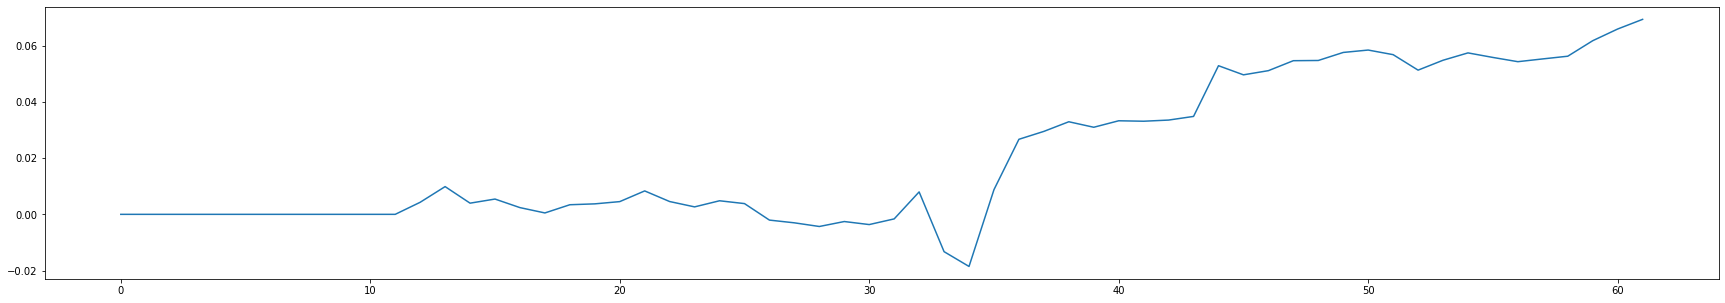

In [45]:
trading_data[columns[0]].cumsum().plot(figsize=(30, 5))

# Predict Candle in real time

In [3]:
dataset = Dataset().get_data(days=10, ticker='BTCUSDT', ts='1h')
features = createFeatures().create_features(dataset[['open', 'high', 'low', 'close']])

0it [00:00, ?it/s]

[X] Ooops!!! It's True, the series 'volume' was not found in open, high, low, close


/home/serg/projects/onramp/quant-ai/models/processing/create_features.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ta.strategy("Momentum")
39it [00:00, 57.63it/s]


In [4]:
cols = features.columns
actual_data = features[cols].tail(12)
expected_prices = []
for j in range(12):
    scaler = ensemble.stores[j].transformer
    model = ensemble.stores[j].model

    data = scaler.scaler_x.transform(actual_data.values)
    predicted = model.predict(data.reshape(-1, 12, len(cols)))
    expected_price = scaler.inverse_min_max_scaler_y(predicted)
    expected_prices.append(expected_price[0])
expected_prices = pd.DataFrame(expected_prices, columns=['open', 'high', 'low', 'close'])
fig = go.Figure(data=[go.Candlestick(
                x=expected_prices.index,
                open=expected_prices['open'],
                high=expected_prices['high'],
                low=expected_prices['low'],
                close=expected_prices['close'])])
fig.show()

1/1 [==============================] - 0s 491ms/step
